<a href="https://colab.research.google.com/github/RafsanJany-44/ARC/blob/master/Kaggle_image_segmentation_U_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#U-Net Original Research Paper
Paper Name: U-Net: Convolutional Networks for Biomedical Image Segmentation<br>
Paper Link: https://arxiv.org/pdf/1505.04597.pdf

#Configs

In [3]:
class ROOTDIR:
    train = "/content/drive/MyDrive/testing_imag_data/archive/data/data/images"
    train_mask = "/content/drive/MyDrive/testing_imag_data/archive/data/data/masks"

#General Imports

In [4]:
import os
import cv2
import zipfile
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

#Working with Train Images and Masks

In [5]:
from PIL import Image

In [8]:
#os.mkdir("masks")
for imgname in os.listdir(ROOTDIR.train_mask):
    img = Image.open('/content/drive/MyDrive/testing_imag_data/archive/data/data/masks/'+imgname) # open colour image
    img = img.convert('L') # convert image to black and white
    img.save('/content/drive/MyDrive/testing_imag_data/archive/data/data/masks/'+imgname)
    '''img=cv2.imread('..\\input\\leaf-disease-segmentation-dataset\\data\\data\\masks'+imgname)
    print(type(img))
    img=cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img=cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    cv2.imwrite(imgname, img)'''

In [9]:
ROOTDIR.train_mask="/content/drive/MyDrive/testing_imag_data/archive/data/data/masks/"

In [10]:
train_img_lst = os.listdir(ROOTDIR.train) # "./train"
train_mask_lst = os.listdir(ROOTDIR.train_mask) # "./train_masks"

In [11]:
print(train_mask_lst[:5])
print(train_img_lst[:5])

['00312.png', '00464.png', '00360.png', '00300.png', '00350.png']
['00017.jpg', '00124.jpg', '00062.jpg', '00091.jpg', '00016.jpg']


In [12]:
print(len(train_mask_lst))
print(len(train_img_lst))

588
588


###Sorting to make sure we get right image and right mask

In [13]:
sorted_train_mask_lst = sorted(train_mask_lst)

In [14]:
sorted_train_img_lst = sorted(train_img_lst)

In [15]:
print(sorted_train_mask_lst[:16])
print(sorted_train_img_lst[:16])

['00000.png', '00001.png', '00002.png', '00003.png', '00004.png', '00005.png', '00006.png', '00007.png', '00008.png', '00009.png', '00010.png', '00011.png', '00012.png', '00013.png', '00014.png', '00015.png']
['00000.jpg', '00001.jpg', '00002.jpg', '00003.jpg', '00004.jpg', '00005.jpg', '00006.jpg', '00007.jpg', '00008.jpg', '00009.jpg', '00010.jpg', '00011.jpg', '00012.jpg', '00013.jpg', '00014.jpg', '00015.jpg']


#Visualizing Images with their Mask
Making sure images and mask are paired correctly.

/content/drive/MyDrive/testing_imag_data/archive/data/data/images/00000.jpg
(326, 235)
<class 'PIL.JpegImagePlugin.JpegImageFile'>


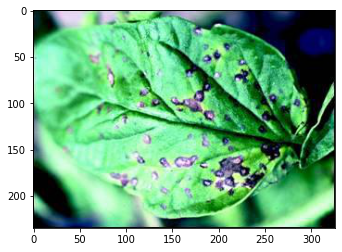

/content/drive/MyDrive/testing_imag_data/archive/data/data/masks/00000.png
(326, 235)


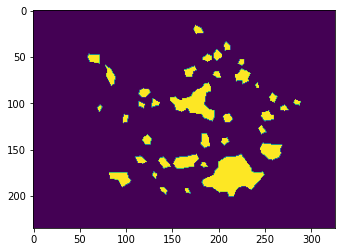

----------------------------------------------------
/content/drive/MyDrive/testing_imag_data/archive/data/data/images/00001.jpg
(326, 234)
<class 'PIL.JpegImagePlugin.JpegImageFile'>


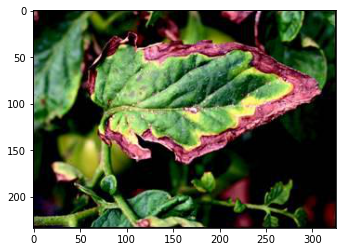

/content/drive/MyDrive/testing_imag_data/archive/data/data/masks/00001.png
(326, 234)


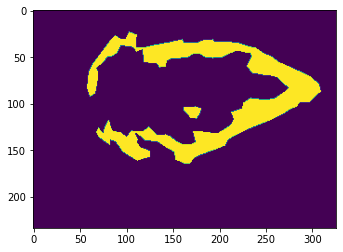

----------------------------------------------------


In [16]:
def show_images(imgs_lst,masks_lst,loops=2):
    for i in range(loops):
        img_path = os.path.join(ROOTDIR.train,imgs_lst[i])
        mask_path = os.path.join(ROOTDIR.train_mask,masks_lst[i])
        img = Image.open(img_path)
        mask = Image.open(mask_path)
        print(img_path)
        print(img.size)
        print(type(img))
        plt.imshow(img)
        plt.show()
        print(mask_path)
        print(mask.size)
        plt.imshow(mask)
        plt.show()
        print("----------------------------------------------------")

show_images(sorted_train_img_lst, sorted_train_mask_lst)

#PyTorch Imports

In [17]:
import torch
import torchvision
import torch.nn as nn
import albumentations as A
import torch.optim as optim
from torchvision import models
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from albumentations.pytorch import ToTensorV2 
from torch.utils.data import DataLoader, Dataset

#PyTorch Configuration

In [18]:
class CFG:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    split_pct = 0.2
    learning_rate = 3e-4
    batch_size = 4
    epochs = 30

In [19]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

In [20]:
CFG.device

device(type='cpu')

#Working with data
Shuffling the data.

In [21]:
#permuted_train_img_lst = np.random.permutation(np.array(sorted_train_img_lst))
#permuted_train_mask_lst = [x.replace(".jpg", "_mask.gif") for x in permuted_train_img_lst]
print(sorted_train_img_lst[:5])
print(sorted_train_mask_lst[:5])

['00000.jpg', '00001.jpg', '00002.jpg', '00003.jpg', '00004.jpg']
['00000.png', '00001.png', '00002.png', '00003.png', '00004.png']


/content/drive/MyDrive/testing_imag_data/archive/data/data/images/00000.jpg
(326, 235)
<class 'PIL.JpegImagePlugin.JpegImageFile'>


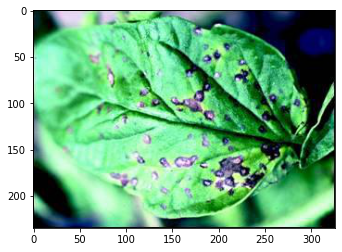

/content/drive/MyDrive/testing_imag_data/archive/data/data/masks/00000.png
(326, 235)


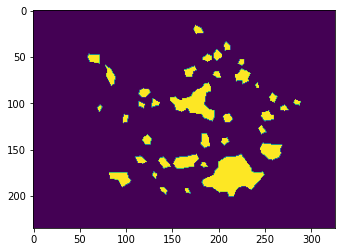

----------------------------------------------------
/content/drive/MyDrive/testing_imag_data/archive/data/data/images/00001.jpg
(326, 234)
<class 'PIL.JpegImagePlugin.JpegImageFile'>


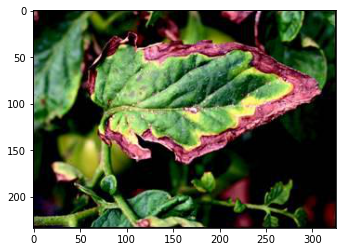

/content/drive/MyDrive/testing_imag_data/archive/data/data/masks/00001.png
(326, 234)


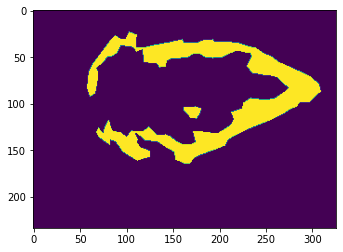

----------------------------------------------------


In [22]:
show_images(sorted_train_img_lst,sorted_train_mask_lst)

###Splitting into Training and Validation

In [23]:
length = len(sorted_train_img_lst)
print(length*0.2) # convert this to int

117.60000000000001


In [24]:
train_images_list = sorted_train_img_lst[int(CFG.split_pct*len(sorted_train_img_lst)) :]
train_masks_list = sorted_train_mask_lst[int(CFG.split_pct*len(sorted_train_mask_lst)) :]
print(len(train_masks_list))

val_images_list = sorted_train_img_lst[: int(CFG.split_pct*len(sorted_train_img_lst))]
val_masks_list = sorted_train_mask_lst[: int(CFG.split_pct*len(sorted_train_mask_lst))]
print(len(val_masks_list))

# 4071+1017=5088 (split includes all items)

471
117


###Visualizing Train Dataset

/content/drive/MyDrive/testing_imag_data/archive/data/data/images/00117.jpg
(257, 348)
<class 'PIL.JpegImagePlugin.JpegImageFile'>


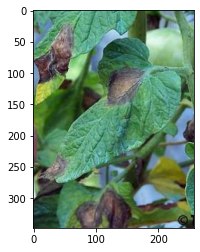

/content/drive/MyDrive/testing_imag_data/archive/data/data/masks/00117.png
(257, 348)


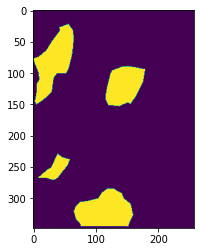

----------------------------------------------------
/content/drive/MyDrive/testing_imag_data/archive/data/data/images/00118.jpg
(269, 271)
<class 'PIL.JpegImagePlugin.JpegImageFile'>


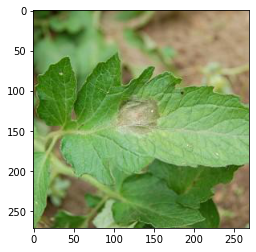

/content/drive/MyDrive/testing_imag_data/archive/data/data/masks/00118.png
(269, 271)


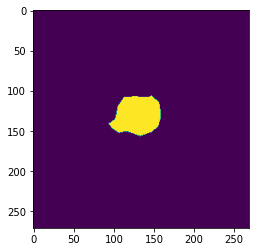

----------------------------------------------------


In [25]:
show_images(train_images_list,train_masks_list)

###Visualizing Validation Dataset

/content/drive/MyDrive/testing_imag_data/archive/data/data/images/00000.jpg
(326, 235)
<class 'PIL.JpegImagePlugin.JpegImageFile'>


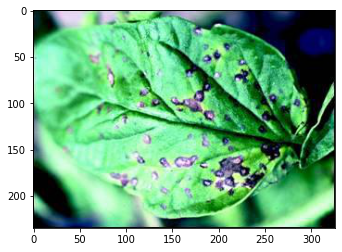

/content/drive/MyDrive/testing_imag_data/archive/data/data/masks/00000.png
(326, 235)


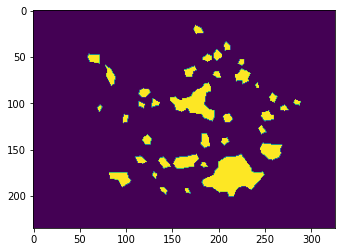

----------------------------------------------------
/content/drive/MyDrive/testing_imag_data/archive/data/data/images/00001.jpg
(326, 234)
<class 'PIL.JpegImagePlugin.JpegImageFile'>


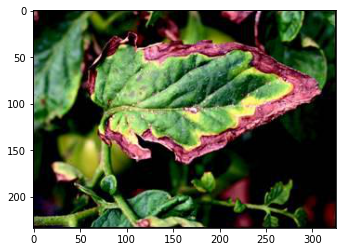

/content/drive/MyDrive/testing_imag_data/archive/data/data/masks/00001.png
(326, 234)


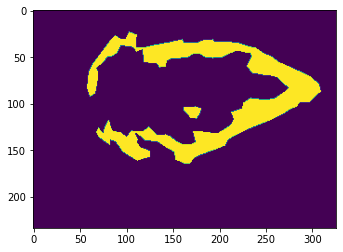

----------------------------------------------------


In [26]:
show_images(val_images_list,val_masks_list)

#Dataset Class